#### Modelo Termodinâmico

Adsorção de microplásticos baseado no modelo de Ising 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
from matplotlib import font_manager

font_path = '../Ruda/Ruda-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [43]:
# Extração da média de cargas: Coulomb e LJ
# B1 - PS

avogrado = 6.02e22

print('B1-PS')
print(round(2.7331632e+22/avogrado,4),'eV - Coulomb')
print(round(-4.0678101e23/avogrado,4),'eV - LJ')

print('\nCBM-Spid')
print(round(-2.449006e+24/avogrado,4),'eV - Coulomb')
print(round(-7.0256926e+23/avogrado,4),'eV - LJ')

print('\nSpid-PS')
print(round(2.95235251e+23/avogrado,4),'eV - Coulomb')
print(round(-5.1449448e+22/avogrado,4),'eV - LJ')

B1-PS
0.454 eV - Coulomb
-6.7572 eV - LJ

CBM-Spid
-40.6812 eV - Coulomb
-11.6706 eV - LJ

Spid-PS
4.9042 eV - Coulomb
-0.8546 eV - LJ


In [62]:
E_CBMP = 0.045   # Energia CBM-MP : 0.045 eV
E_CBMS = - 40.7   # Energia CBM-Espid
E_SMP = 4.9    # Energia Espid-MP

# E_CBMP = 0.5   # Energia CBM-MP : 0.045 eV
# E_CBMS = - 0.1   # Energia CBM-Espid
# E_SMP = 0.2    # Energia Espid-MP

E_CBMCBM = 0.2  # Energia CBM-CBM
E_SS = 0.2      # Energia Espid-Espid
E_MPMP = 0.1    # Energia MP-MP

In [63]:
def calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP):
    energia = 0
    tamanho = len(rede)
    for i in range(tamanho):
        for j in range(tamanho):
            S = rede[i, j]
            if S == 0:
                continue

            # Interacao Vizinhos
            vizinhos = [
                rede[(i+1) % tamanho, j],
                rede[i, (j+1) % tamanho],
                rede[(i-1) % tamanho, j],
                rede[i, (j-1) % tamanho]
            ]
            
            for V in vizinhos:
                if S == 1:  # CBM
                    if V == -1:  # CBM com MP
                        energia += E_CBMP
                    elif V == 2:  # CBM com espid
                        energia += E_CBMS
                    elif V == 1:  # CBM com CBM
                        energia += E_CBMCBM
                elif S == 2:  # Espid
                    if V == -1:  # Espid com MP
                        energia += E_SMP
                    elif V == 2:  # Espid com espid
                        energia += E_SS
                elif S == -1:  # MP
                    if V == -1:  # MP com MP
                        energia += E_MPMP

    return energia

def monte_carlo(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP, T, passos):
    tamanho = len(rede)
    for passo in range(passos):
        
        # Posicao aleatoria na rede
        i = np.random.randint(0, tamanho)
        j = np.random.randint(0, tamanho)
        S = rede[i, j]
        
        # Proteinas CBM e espid não mudam de posicao, ignoramos
        if S == 1 or S == 2:
            continue
        
        # Calcular a energia atual e a energia se mudar o estado
        energia_antiga = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
        novo_estado = np.random.choice([-1, 0])  # Tenta alterar o estado para MP ou vazio
        rede[i, j] = novo_estado
        energia_nova = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
        
        # Decisao de aceitar ou nao a mudanca
        delta_energia = energia_nova - energia_antiga
        if delta_energia > 0 and np.random.rand() >= np.exp(-delta_energia / T):
            rede[i, j] = S  # Reverter se nao aceitar
        
    return rede

# Funcao para calcular a eficiencia do sistema
def calcular_eficiencia(energias):
    energia_inicial = energias[0]
    energia_final = energias[-1]
    eficiencia = (energia_inicial - energia_final) / abs(energia_inicial)
    return eficiencia

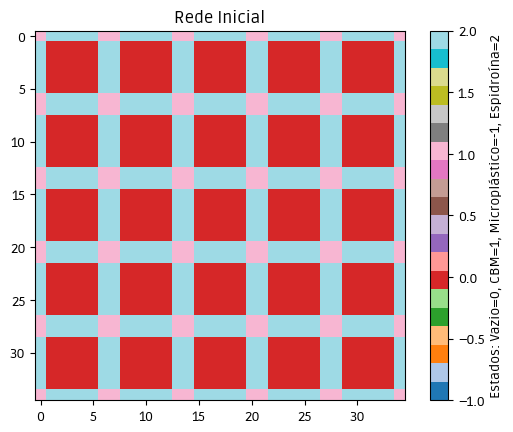

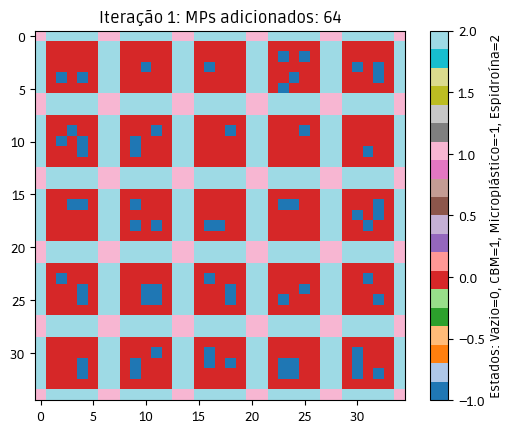

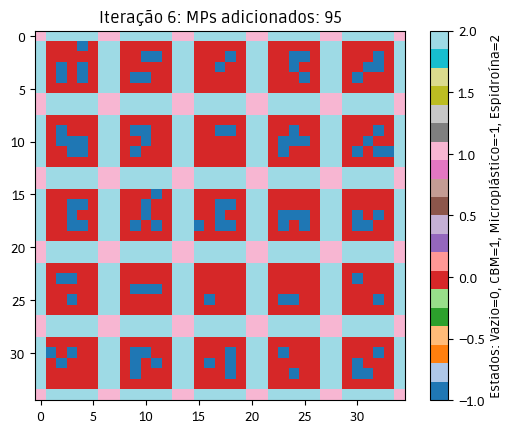

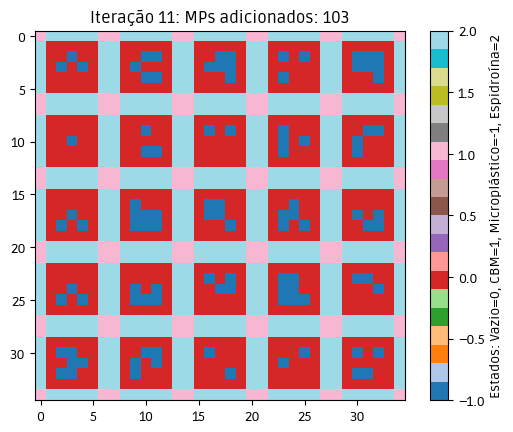

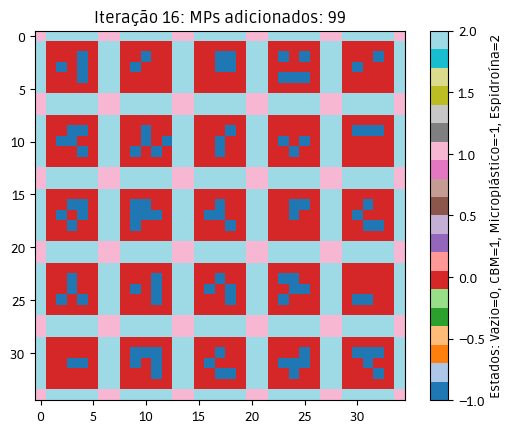

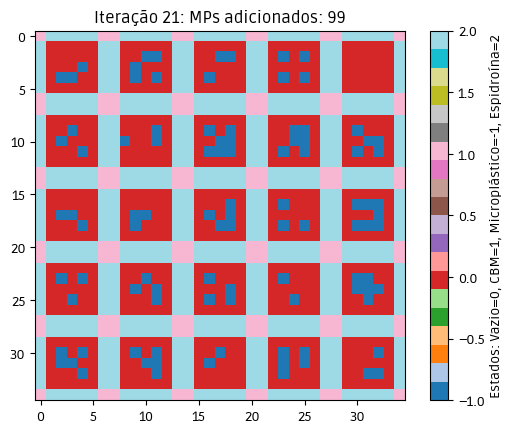

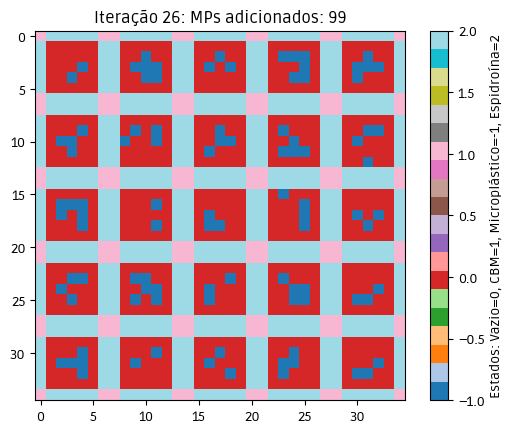

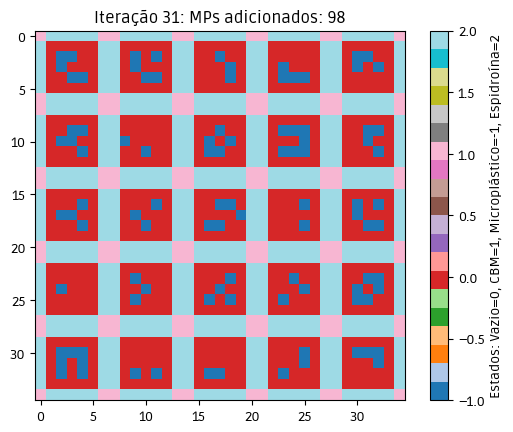

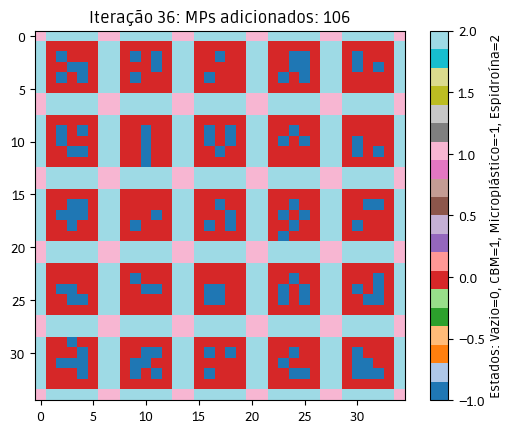

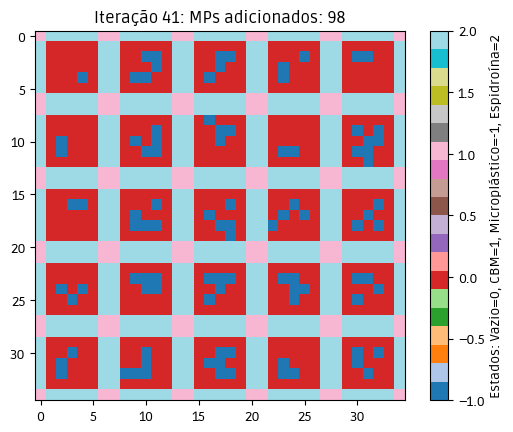

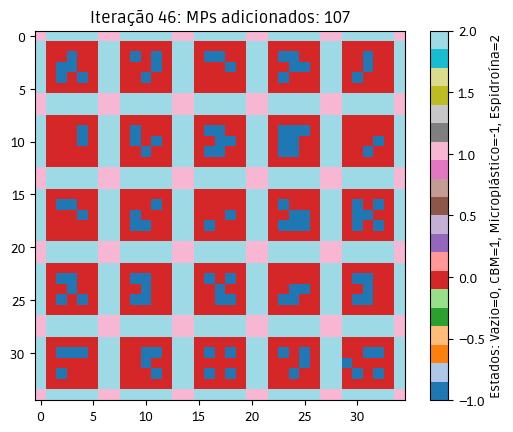

In [67]:
# Parametros do modelo
tamanho_rede = 35 # rede quadrática
T = 1.0  # temperatura
passos = 1000  # número de passos de Monte Carlo por adição de microplástico

# Padrao 7x7 que sera repetido
padrao = np.array([
    [1, 2, 2, 2, 2, 2, 1],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [1, 2, 2, 2, 2, 2, 1],
])

rede = np.tile(padrao, (tamanho_rede // 7, tamanho_rede // 7))

it = 50 # iteracoes

# mps,energias = [0],[]
mps,energias = [],[]

energia_inicial = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
# energias.append(energia_inicial)

plt.imshow(rede, cmap='tab20', vmin=-1, vmax=2)
plt.title('Rede Inicial')
plt.colorbar(label='Estados: Vazio=0, CBM=1, Microplástico=-1, Espidroína=2')
plt.show()

for n in range(it):

    rede = monte_carlo(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP, T, passos)

    energia_atual = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
    energias.append(energia_atual)
    
    mps_add = list(rede.flatten()).count(-1)
    mps.append(mps_add)
    
    if n % 5 == 0:
    # if False:
        plt.imshow(rede, cmap='tab20', vmin=-1, vmax=2)
        plt.title(f'Iteração {n+1}: MPs adicionados: {mps_add}')
        plt.colorbar(label='Estados: Vazio=0, CBM=1, Microplástico=-1, Espidroína=2')
        plt.pause(0.5)

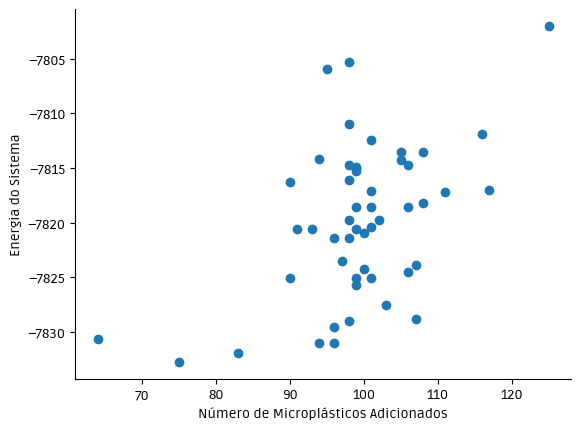

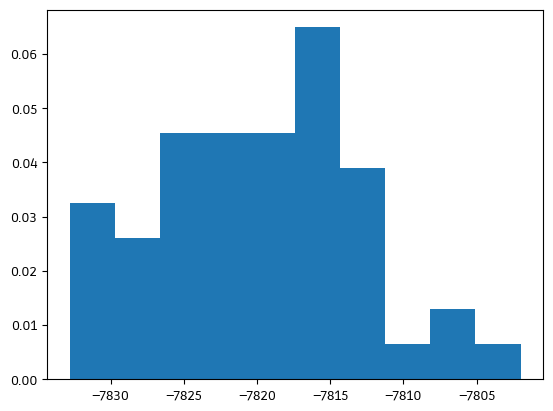

Eficiência do sistema: -0.00


In [68]:
plt.figure()
plt.scatter(mps, energias)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Número de Microplásticos Adicionados')
plt.ylabel('Energia do Sistema')
plt.show()

plt.hist(energias,density=True);plt.show()

eficiencia = calcular_eficiencia(energias)
print(f'Eficiência do sistema: {eficiencia:.2f}')